In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [8]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        
        
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [9]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [10]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [11]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [12]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [13]:
class CopiedMultivariateStudentT(TorchDistribution):
    """
    Creates a multivariate Student's t-distribution parameterized by degree of
    freedom :attr:`df`, mean :attr:`loc` and scale :attr:`scale_tril`.

    :param ~torch.Tensor df: degrees of freedom
    :param ~torch.Tensor loc: mean of the distribution
    :param ~torch.Tensor scale_tril: scale of the distribution, which is
        a lower triangular matrix with positive diagonal entries
    """

    arg_constraints = {
        "df": constraints.positive,
        "loc": constraints.real_vector,
        "scale_tril": constraints.lower_cholesky,
    }
    support = constraints.real_vector
    has_rsample = True

    def __init__(self, df, loc, scale_tril, validate_args=None):
        dim = loc.size(-1)
        assert scale_tril.shape[-2:] == (dim, dim)
        if not isinstance(df, torch.Tensor):
            df = loc.new_tensor(df)
        batch_shape = broadcast_shape(df.shape, loc.shape[:-1], scale_tril.shape[:-2])
        event_shape = torch.Size((dim,))
        self.df = df.expand(batch_shape)
        self.loc = loc.expand(batch_shape + event_shape)
        self._unbroadcasted_scale_tril = scale_tril
        self._chi2 = Chi2(self.df)
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    @lazy_property
    def scale_tril(self):
        return self._unbroadcasted_scale_tril.expand(
            self._batch_shape + self._event_shape + self._event_shape
        )

    @lazy_property
    def covariance_matrix(self):
        # NB: this is not covariance of this distribution;
        # the actual covariance is df / (df - 2) * covariance_matrix
        return torch.matmul(
            self._unbroadcasted_scale_tril,
            self._unbroadcasted_scale_tril.transpose(-1, -2),
        ).expand(self._batch_shape + self._event_shape + self._event_shape)

    @lazy_property
    def precision_matrix(self):
        identity = torch.eye(
            self.loc.size(-1), device=self.loc.device, dtype=self.loc.dtype
        )
        return torch.cholesky_solve(identity, self._unbroadcasted_scale_tril).expand(
            self._batch_shape + self._event_shape + self._event_shape
        )

    @staticmethod
    def infer_shapes(df, loc, scale_tril):
        event_shape = loc[-1:]
        batch_shape = broadcast_shape(df, loc[:-1], scale_tril[:-2])
        return batch_shape, event_shape

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(MultivariateStudentT, _instance)
        batch_shape = torch.Size(batch_shape)
        loc_shape = batch_shape + self.event_shape
        scale_shape = loc_shape + self.event_shape
        new.df = self.df.expand(batch_shape)
        new.loc = self.loc.expand(loc_shape)
        new._unbroadcasted_scale_tril = self._unbroadcasted_scale_tril
        if "scale_tril" in self.__dict__:
            new.scale_tril = self.scale_tril.expand(scale_shape)
        if "covariance_matrix" in self.__dict__:
            new.covariance_matrix = self.covariance_matrix.expand(scale_shape)
        if "precision_matrix" in self.__dict__:
            new.precision_matrix = self.precision_matrix.expand(scale_shape)
        new._chi2 = self._chi2.expand(batch_shape)
        super(MultivariateStudentT, new).__init__(
            batch_shape, self.event_shape, validate_args=False
        )
        new._validate_args = self._validate_args
        return new


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        X = torch.empty(shape, dtype=self.df.dtype, device=self.df.device).normal_()
        Z = self._chi2.rsample(sample_shape)
        Y = X * torch.rsqrt(Z / self.df).unsqueeze(-1)
        return self.loc + self.scale_tril.matmul(Y.unsqueeze(-1)).squeeze(-1)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.loc.size(-1)
        y = torch.linalg.solve_triangular(
            self.scale_tril, (value - self.loc).unsqueeze(-1), upper=False
        ).squeeze(-1)
        
        print(y.shape)
        print(y)
        
        diff - value-self.loc
        
        M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
        
        half_log_det = self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
        
        lhs = (
            - torch.lgamma(0.5 * self.df)
            + torch.lgamma(0.5 * (self.df + n))
            - 0.5 * self.df * math.log(self.df)
            - 0.5 * self.df * math.log(math.pi)
            - half_log_det
        )
        
        rhs = -0.5 * (self.df + n) * torch.log1p((1./self.df) * M)
        return lhs + rhs
        
        

    @property
    def mean(self):
        m = self.loc.clone()
        m[self.df <= 1, :] = float("nan")
        return m

    @property
    def variance(self):
        m = self.scale_tril.pow(2).sum(-1) * (self.df / (self.df - 2)).unsqueeze(-1)
        m[(self.df <= 2) & (self.df > 1), :] = float("inf")
        m[self.df <= 1, :] = float("nan")
        return m

NameError: name 'TorchDistribution' is not defined

In [62]:
import math

import torch
from torch.distributions import constraints
from torch.distributions.utils import lazy_property

from pyro.distributions.torch import Chi2
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.util import broadcast_shape

from torch.distributions.multivariate_normal import _batch_mahalanobis, _batch_mv
from torch.distributions.utils import _standard_normal, lazy_property


def _batch_capacitance_tril(W, D):
    """
    Computes Cholesky of :math:`I + W.T @ inv(D) @ W` for a batch of matrices :math:`W`
    and a batch of vectors :math:`D`.
    """
    m = W.size(-1)
    Wt_Dinv = W.mT / D.unsqueeze(-2)
    K = torch.matmul(Wt_Dinv, W).contiguous()
    K.view(-1, m * m)[:, ::m + 1] += 1  # add identity matrix to K
    return torch.linalg.cholesky(K)


def _batch_lowrank_logdet(W, D, capacitance_tril):
    r"""
    Uses "matrix determinant lemma"::
        log|W @ W.T + D| = log|C| + log|D|,
    where :math:`C` is the capacitance matrix :math:`I + W.T @ inv(D) @ W`, to compute
    the log determinant.
    """
    return 2 * capacitance_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1) + D.log().sum(-1)


def _batch_lowrank_mahalanobis(W, D, x, capacitance_tril):
    r"""
    Uses "Woodbury matrix identity"::
        inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D),
    where :math:`C` is the capacitance matrix :math:`I + W.T @ inv(D) @ W`, to compute the squared
    Mahalanobis distance :math:`x.T @ inv(W @ W.T + D) @ x`.
    """
    Wt_Dinv = W.mT / D.unsqueeze(-2)
    Wt_Dinv_x = _batch_mv(Wt_Dinv, x)
    mahalanobis_term1 = (x.pow(2) / D).sum(-1)
    mahalanobis_term2 = _batch_mahalanobis(capacitance_tril, Wt_Dinv_x)
    return mahalanobis_term1 - mahalanobis_term2

class LowRankMultivariateStudentT(TorchDistribution):
    """
    Creates a low rank multivariate Student's t-distribution parameterized by degree of
    freedom :attr:`df`, mean :attr:`loc` and :attr:`cov_factor` and :attr:`cov_diag`
     
     covariance_matrix = cov_factor @ cov_factor.T + cov_diag

    :param ~torch.Tensor df: degrees of freedom
    :param ~torch.Tensor loc: mean of the distribution
    :param ~torch.Tensor cov_factor (Tensor): factor part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape + (rank,)`
    :param ~torch.Tensor  cov_diag (Tensor): diagonal part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape`

    Note:
        The computation for determinant and inverse of covariance matrix is avoided when
        `cov_factor.shape[1] << cov_factor.shape[0]` thanks to `Woodbury matrix identity
        <https://en.wikipedia.org/wiki/Woodbury_matrix_identity>`_ and
        `matrix determinant lemma <https://en.wikipedia.org/wiki/Matrix_determinant_lemma>`_.
        Thanks to these formulas, we just need to compute the determinant and inverse of
        the small size "capacitance" matrix::
    """

    arg_constraints = {
        "df": constraints.positive,
        "loc": constraints.real_vector,
        "cov_factor": constraints.independent(constraints.real, 2),
        "cov_diag": constraints.independent(constraints.positive, 1)
    }
    support = constraints.real_vector
    has_rsample = True

    def __init__(self, df, loc, cov_factor, cov_diag, validate_args=None):
        dim = loc.size(-1)
        if not isinstance(df, torch.Tensor):
            df = loc.new_tensor(df)
        event_shape = loc.shape[-1:]
            
        if loc.dim() < 1:
            raise ValueError("loc must be at least one-dimensional.")
        
            
        if cov_factor.dim() < 2:
            raise ValueError("cov_factor must be at least two-dimensional, "
                             "with optional leading batch dimensions")
        if cov_factor.shape[-2:-1] != event_shape:
            raise ValueError("cov_factor must be a batch of matrices with shape {} x m"
                             .format(event_shape[0]))
        if cov_diag.shape[-1:] != event_shape:
            raise ValueError("cov_diag must be a batch of vectors with shape {}".format(event_shape))

        
        loc_ = loc.unsqueeze(-1)
        cov_diag_ = cov_diag.unsqueeze(-1)
        try:
            loc_, self.cov_factor, cov_diag_ = torch.broadcast_tensors(loc_, cov_factor, cov_diag_)
        except RuntimeError as e:
            raise ValueError("Incompatible batch shapes: loc {}, cov_factor {}, cov_diag {}"
                             .format(loc.shape, cov_factor.shape, cov_diag.shape)) from e
        self.loc = loc_[..., 0]
        self.cov_diag = cov_diag_[..., 0]
        batch_shape = self.loc.shape[:-1]
            
        #batch_shape = broadcast_shape(df.shape, loc.shape[:-1], scale_tril.shape[:-2])
        event_shape = torch.Size((dim,))
        self.df = df.expand(batch_shape)
        self.loc = loc.expand(batch_shape + event_shape)
        cov_diag_ = cov_diag.unsqueeze(-1)
    
        self._unbroadcasted_cov_factor = cov_factor
        self._unbroadcasted_cov_diag = cov_diag
        self._capacitance_tril = _batch_capacitance_tril(cov_factor, cov_diag)
    
        self._chi2 = Chi2(self.df)
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    @lazy_property
    def scale_tril(self):
        # The following identity is used to increase the numerically computation stability
        # for Cholesky decomposition (see http://www.gaussianprocess.org/gpml/, Section 3.4.3):
        #     W @ W.T + D = D1/2 @ (I + D-1/2 @ W @ W.T @ D-1/2) @ D1/2
        # The matrix "I + D-1/2 @ W @ W.T @ D-1/2" has eigenvalues bounded from below by 1,
        # hence it is well-conditioned and safe to take Cholesky decomposition.
        n = self._event_shape[0]
        cov_diag_sqrt_unsqueeze = self._unbroadcasted_cov_diag.sqrt().unsqueeze(-1)
        Dinvsqrt_W = self._unbroadcasted_cov_factor / cov_diag_sqrt_unsqueeze
        K = torch.matmul(Dinvsqrt_W, Dinvsqrt_W.mT).contiguous()
        K.view(-1, n * n)[:, ::n + 1] += 1  # add identity matrix to K
        scale_tril = cov_diag_sqrt_unsqueeze * torch.linalg.cholesky(K)
        return scale_tril.expand(self._batch_shape + self._event_shape + self._event_shape)

    @lazy_property
    def covariance_matrix(self):
        # NB: this is not covariance of this distribution;
        # the actual covariance is df / (df - 2) * covariance_matrix
        covariance_matrix = (torch.matmul(self._unbroadcasted_cov_factor,
                                          self._unbroadcasted_cov_factor.mT)
                             + torch.diag_embed(self._unbroadcasted_cov_diag))
        return covariance_matrix.expand(self._batch_shape + self._event_shape +
                                        self._event_shape)


    @lazy_property
    def precision_matrix(self):
        # We use "Woodbury matrix identity" to take advantage of low rank form::
        #     inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D)
        # where :math:`C` is the capacitance matrix.
        Wt_Dinv = (self._unbroadcasted_cov_factor.mT
                   / self._unbroadcasted_cov_diag.unsqueeze(-2))
        A = torch.linalg.solve_triangular(self._capacitance_tril, Wt_Dinv, upper=False)
        precision_matrix = torch.diag_embed(self._unbroadcasted_cov_diag.reciprocal()) - A.mT @ A
        return precision_matrix.expand(self._batch_shape + self._event_shape +
                                       self._event_shape)


    @staticmethod
    def infer_shapes(df, loc, scale_tril):
        event_shape = loc[-1:]
        batch_shape = broadcast_shape(df, loc[:-1], scale_tril[:-2])
        return batch_shape, event_shape

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LowRankMultivariateStudentT, _instance)
        batch_shape = torch.Size(batch_shape)
        loc_shape = batch_shape + self.event_shape
        scale_shape = loc_shape + self.event_shape
        new.df = self.df.expand(batch_shape)
        new.loc = self.loc.expand(loc_shape)
        new.cov_diag = self.cov_diag.expand(loc_shape)
        new.cov_factor = self.cov_factor.expand(loc_shape + self.cov_factor.shape[-1:])
        new._unbroadcasted_cov_factor = self._unbroadcasted_cov_factor
        new._unbroadcasted_cov_diag = self._unbroadcasted_cov_diag
        new._capacitance_tril = self._capacitance_tril
        if "scale_tril" in self.__dict__:
            new.scale_tril = self.scale_tril.expand(scale_shape)
        if "covariance_matrix" in self.__dict__:
            new.covariance_matrix = self.covariance_matrix.expand(scale_shape)
        if "precision_matrix" in self.__dict__:
            new.precision_matrix = self.precision_matrix.expand(scale_shape)
        new._chi2 = self._chi2.expand(batch_shape)
        
        super(LowRankMultivariateStudentT, new).__init__(batch_shape,
                                                       self.event_shape,
                                                       validate_args=False)
        new._validate_args = self._validate_args
        return new

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        W_shape = shape[:-1] + self.cov_factor.shape[-1:]
        eps_W = _standard_normal(W_shape, dtype=self.loc.dtype, device=self.loc.device)
        eps_D = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        
        Y = _batch_mv(self._unbroadcasted_cov_factor, eps_W) + self._unbroadcasted_cov_diag.sqrt() * eps_D
        
        Z = self._chi2.rsample(sample_shape)
        
        scaled_sample = (torch.rsqrt(Z / self.df).unsqueeze(-1) * Y).squeeze(-1)
        return self.loc + scaled_sample 

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.loc.size(-1)
        # y = torch.linalg.solve_triangular(
        #     self.scale_tril, (value - self.loc).unsqueeze(-1), upper=False
        # ).squeeze(-1)
        
        print("not sure this is right")
        
        diff = value - self.loc
        M = _batch_lowrank_mahalanobis(self._unbroadcasted_cov_factor,
                                       self._unbroadcasted_cov_diag,
                                       diff,
                                       self._capacitance_tril)
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        
        Z = (
            0.5 * log_det
            + 0.5 * n * self.df.log()
            + 0.5 * n * math.log(math.pi)
            + torch.lgamma(0.5 * self.df)
            - torch.lgamma(0.5 * (self.df + n))
        )
        
        
        return -0.5 * (self.df + n) * torch.log1p(M.pow(2).sum(-1) / self.df) - Z


    @property
    def mean(self):
        m = self.loc.clone()
        m[self.df <= 1, :] = float("nan")
        return m

    @property
    def variance(self):
        sigma = (self._unbroadcasted_cov_factor.pow(2).sum(-1)
                + self._unbroadcasted_cov_diag).expand(self._batch_shape + self._event_shape)
        m = (sigma * (self.df / (self.df - 2)))
        m[(self.df <= 2) & (self.df > 1), :] = float("inf")
        m[self.df <= 1, :] = float("nan")
        return m
    
    def entropy(self):
        print("not implemented")
        raise ValueError("ben did not implement this did he now. No entropy on low rank multivariate student t")

In [669]:
from pyro.distributions import MultivariateStudentT
import torch.distributions as td

In [754]:
loc = torch.Tensor([1.,2., 3., 4., 5.])
n = loc.shape[0]
v = 1e6

In [755]:
x = torch.randn(loc.shape)*0 + loc

In [756]:
D = torch.Tensor([0.5, 0.5, 0.5, 0.5, 0.5]) * 0.5
P = torch.rand(5, 5)

In [757]:
cov = P @ P.T + D
scale_tril = torch.linalg.cholesky(cov)

In [758]:
n1 = td.MultivariateNormal(loc, cov)
n2 = td.LowRankMultivariateNormal(loc, P, D)

In [759]:
n1.log_prob(x).exp(), n2.log_prob(x).exp()

(tensor(0.2440), tensor(0.0226))

In [760]:
t1 = MultivariateStudentT(v, loc, scale_tril)
t2 = LowRankMultivariateStudentT(v, loc, P, D)

In [763]:
s1 = t1.rsample((1000,))
s2 = t2.rsample((1000,))

# s1 = n1.rsample((1000,))
# s2 = n2.rsample((1000,))

In [764]:
s1.shape

torch.Size([1000, 5])

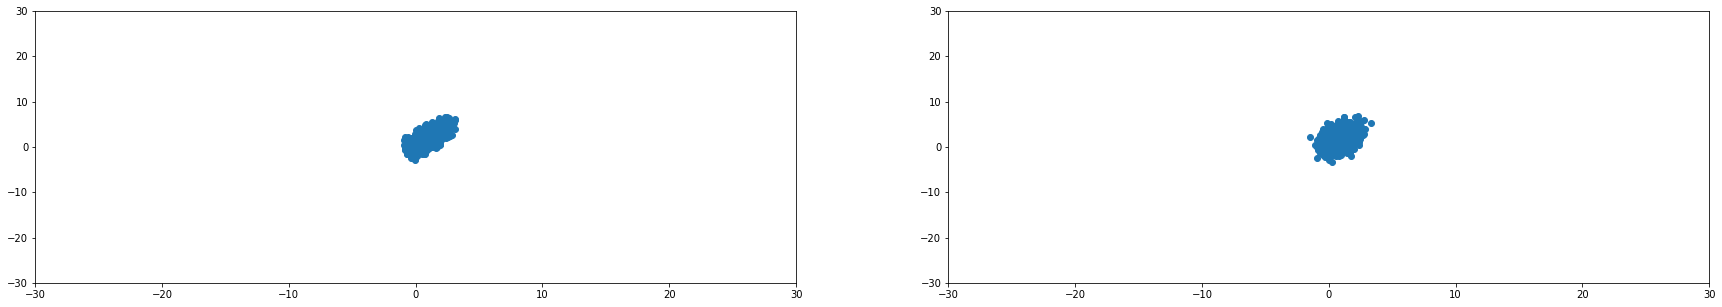

In [765]:
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.scatter(s1[:,0], s1[:,1])
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.subplot(1,2,2)
plt.scatter(s2[:,0], s2[:,1]);
plt.xlim(-30,30)
plt.ylim(-30,30);

In [148]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rMultivariateEvidential(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean0_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov0_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov0_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')
        self.k0 = conv_func(decoder_features[-1], 1, kernel_size = (7,) *  dims)
        self.n0 = conv_func(decoder_features[-1], 1, kernel_size = (7,) *  dims)

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean0_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov0_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov0_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
            
        n0 = torch.nn.functional.avg_pool2d(self.n0(logits), kernel_size=7).view((batch_size, -1)).mean(dim=1)
        out_dims = (x.shape[-2] * x.shape[-1]) ** 2.
        n0 = n0.exp() + out_dims
        k0 = torch.nn.functional.avg_pool2d(self.k0(logits), kernel_size=7).view((batch_size, -1)).mean(dim=1)
        k0 = k0.exp()
        
        df = n0 - out_dims + 1.
        sc = (k0 + 1.)/(k0*(n0-out_dims + 1.))
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.StudentT(df=2, loc=mean, scale=torch.sqrt(cov_diag * sc)), 1)
        else:
            try:
                base_distribution = LowRankMultivariateStudentT(df=2, loc=mean, cov_factor=cov_factor * (sc**0.5), cov_diag=cov_diag * sc)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = td.TransformedDistribution(base_distribution, td.SigmoidTransform())
        
        distribution = ReshapedDistribution(distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

### setup model

In [149]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
#     model = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }
#                    )
    
    # model = HyperMapp3rDDU(dims=2,
    #              in_channels=3,
    #              out_channels=2,
    #              encoder_features=[16, 32, 64, 128, 256],
    #              decoder_features=[128, 64, 32, 16],
    #              softmax=False,
    #              up_res_blocks=True,
    #              n_power_iterations=3, 
    #              eps=1e-12,
    #              block_params={
    #                  "dropout_p":0.1,
    #                  "norm_type":"in", 
    #                  "dropout_both_layers":False,
    #              }
    #                )
    
    model_raw = HyperMapp3rMultivariateEvidential(dims=2,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    #optimizer_params={"lr":2e-3}
    #lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [150]:
summary(model_raw)

Layer (type:depth-idx)                   Param #
HyperMapp3rMultivariateEvidential        --
├─ModuleList: 1-1                        --
│    └─HM3Block: 2-1                     --
│    │    └─Conv2d: 3-1                  2,304
│    │    └─Dropout2d: 3-2               --
│    │    └─InstanceNorm2d: 3-3          --
│    │    └─Conv2d: 3-4                  2,304
│    │    └─InstanceNorm2d: 3-5          --
│    │    └─LeakyReLU: 3-6               --
│    └─HM3Block: 2-2                     --
│    │    └─Conv2d: 3-7                  9,216
│    │    └─Dropout2d: 3-8               --
│    │    └─InstanceNorm2d: 3-9          --
│    │    └─Conv2d: 3-10                 9,216
│    │    └─InstanceNorm2d: 3-11         --
│    │    └─LeakyReLU: 3-12              --
│    └─HM3Block: 2-3                     --
│    │    └─Conv2d: 3-13                 36,864
│    │    └─Dropout2d: 3-14              --
│    │    └─InstanceNorm2d: 3-15         --
│    │    └─Conv2d: 3-16                 36,864
│    │ 

In [151]:
#model.load_state_dict(torch.load("ssn_trained_no_wrapper_class.ckpt"))

In [152]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class StandardLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, **kwargs):
        return self.model(x, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [153]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [154]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math


class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        #log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        log_prob = logit_sample.view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss

In [155]:
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples,))
        return samples


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))

In [156]:
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [157]:
def analytic_log_loss(out, target):
    return -out.log_prob(target)

In [164]:
ssn_diceloss = SsnNetworkSampleLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

def double_loss(outs, target):
    #return ssn_diceloss(outs, target) * 10 + analytic_log_loss(outs['distribution'], target) * 0.01
    return analytic_log_loss(outs['distribution'], target.type(torch.float32)) * 0.01

In [165]:
# loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)
# loss = SsnNetworkSampleLossWrapper(dice_loss)
loss = double_loss

In [166]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [170]:
model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )


# checkpoint= "ed_domains_ssn_trained.ckpt"
# model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=double_loss, logging_metric=SsnDiceMetricWrapper)

In [171]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [172]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | HyperMapp3rMultivariateEvidential | 2.8 M 
------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.112    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

was thrown:  The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 2
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')
was thrown:  The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 2
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


Training: 0it [00:00, ?it/s]

was thrown:  The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 2
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
trainer.validate(model, val_dataloader)

In [ ]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [871]:
with torch.no_grad():
    x, y = next(iter(val_dataloader))
    pred = model(x.to(model.device))
    

In [872]:
samples = pred['distribution'].rsample((14,))

In [873]:
ent_map = entropy_map_from_samples(samples)

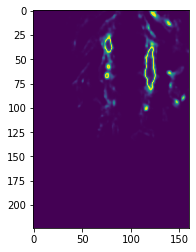

In [874]:
plt.imshow(ent_map[28])

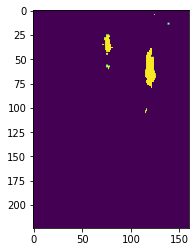

In [875]:
plt.imshow(y[28])

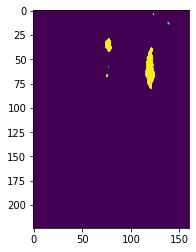

In [876]:
plt.imshow(samples[9][28].argmax(dim=0));

In [877]:
from tqdm import tqdm

In [878]:
all_tps = []
all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        pred = model(x)
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ent = entropy_map_from_samples(samples).view([-1])
        mean = pred['logit_mean']
        mean_class = mean.argmax(dim=1).view(-1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:31<00:00,  3.78s/it]


In [879]:
tps = torch.cat(all_tps)
tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [880]:
tps.shape, tns.shape, fps.shape, fns.shape

(torch.Size([593809]),
 torch.Size([39680860]),
 torch.Size([154732]),
 torch.Size([201984]))

In [881]:
tps.mean(), tns.mean(), fps.mean(), fns.mean()

(tensor(0.2946), tensor(0.0289), tensor(0.5526), tensor(0.4453))

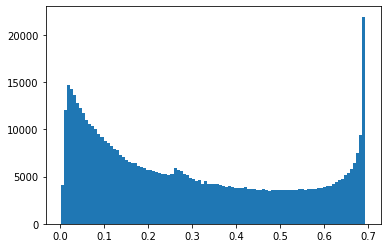

In [882]:
plt.hist(tps, bins=100);

In [883]:
#plt.hist(tns, bins=100);

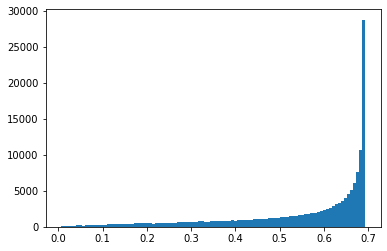

In [884]:
plt.hist(fps, bins=100);

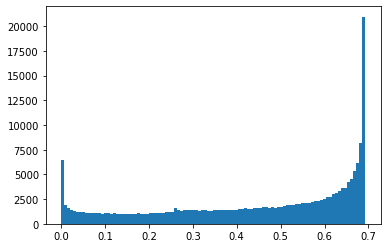

In [885]:
plt.hist(fns, bins=100);

### count the number of missing lesions per image.

In [886]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [887]:
ys = []
conncomp_outs = []
ents_out = []
means_out = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)
        ys.append(y)

        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ents_out.append(entropy_map_from_samples(samples))
        means_out.append(pred['logit_mean'].cpu())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:49<00:00,  2.74s/it]


In [888]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
missing_lesion_size_mean = []
existing_lesion_size_mean = []
for batch in tqdm(range(len(ys)), position=0, leave=True, ncols=150):
    for i in range(ys[batch].shape[0]):
        conncomps = conncomp_outs[batch][i]
        ent = ents_out[batch][i]
        ent_thresh = (ent > 0.1).type(torch.long)
        mean = means_out[batch][i].argmax(dim=0).type(torch.long)
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(mean * cc) > 0:
                existing_lesion_size_mean.append(size)
            else:
                missing_lesion_size_mean.append(size)
            
            if torch.max(ent_thresh * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


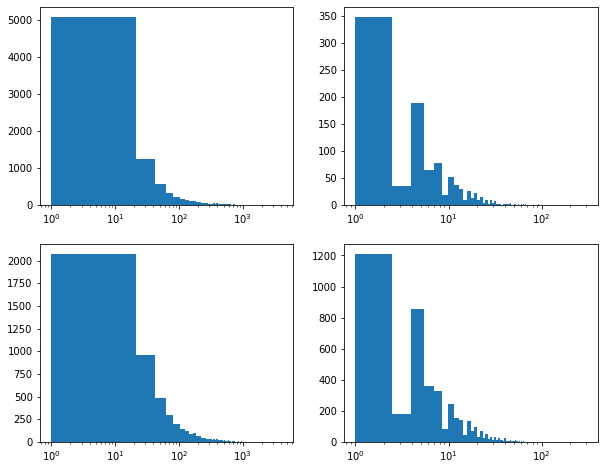

In [889]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.hist(existing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.subplot(2,2,2)
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')

plt.subplot(2,2,3)
plt.hist(existing_lesion_size_mean, bins=200);
plt.xscale('log')
plt.subplot(2,2,4)
plt.hist(missing_lesion_size_mean, bins=200);
plt.xscale('log')

In [890]:
print("means")
torch.Tensor(existing_lesion_size_ent).mean(), torch.Tensor(missing_lesion_size_ent).mean(), torch.Tensor(existing_lesion_size_mean).mean(), torch.Tensor(missing_lesion_size_mean).mean()

means


(tensor(91.1438), tensor(8.5060), tensor(142.2724), tensor(10.8785))

In [891]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [892]:
slice_dices = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, ncols=150, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        
        for i in range(y.shape[0]):
            ind_dices = []
            for s in samples[:,i]:
                ind_dices.append(slice_dice(s, y[i]))
            slice_dices.append(ind_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:29<00:00,  6.74s/it]


In [893]:
# remove na images 
filtered_slice_dices = [x for x in slice_dices if 'n/a' not in x]

In [894]:
means = [torch.mean(torch.Tensor(x)) for x in filtered_slice_dices]

In [895]:
inds = torch.Tensor(means).sort()[1]

In [896]:
random_selection_inds = inds[torch.randint(0, len(inds), (200,)).sort()[0]]

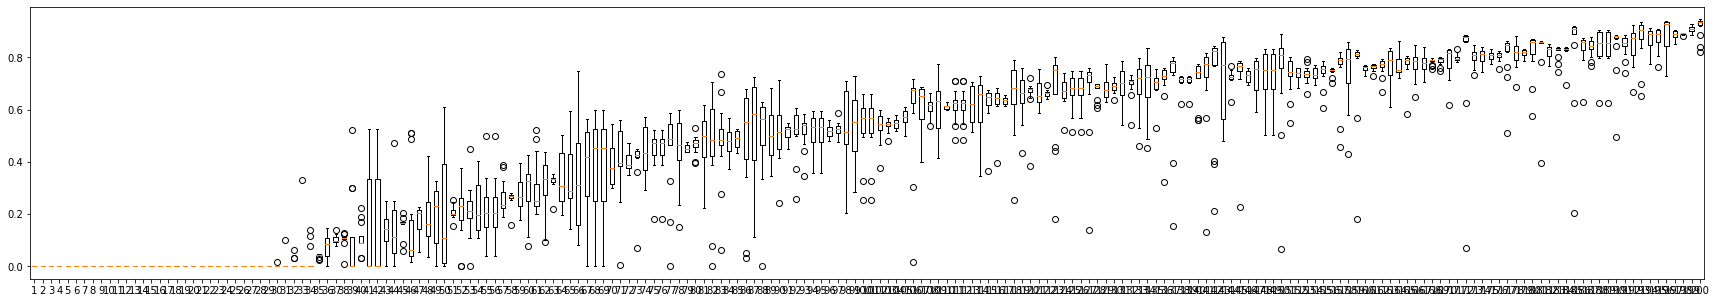

In [897]:
plt.figure(figsize=(30, 5))
plt.boxplot(torch.Tensor(filtered_slice_dices)[random_selection_inds]);

In [898]:
x, y, = next(iter(val_dataloader))

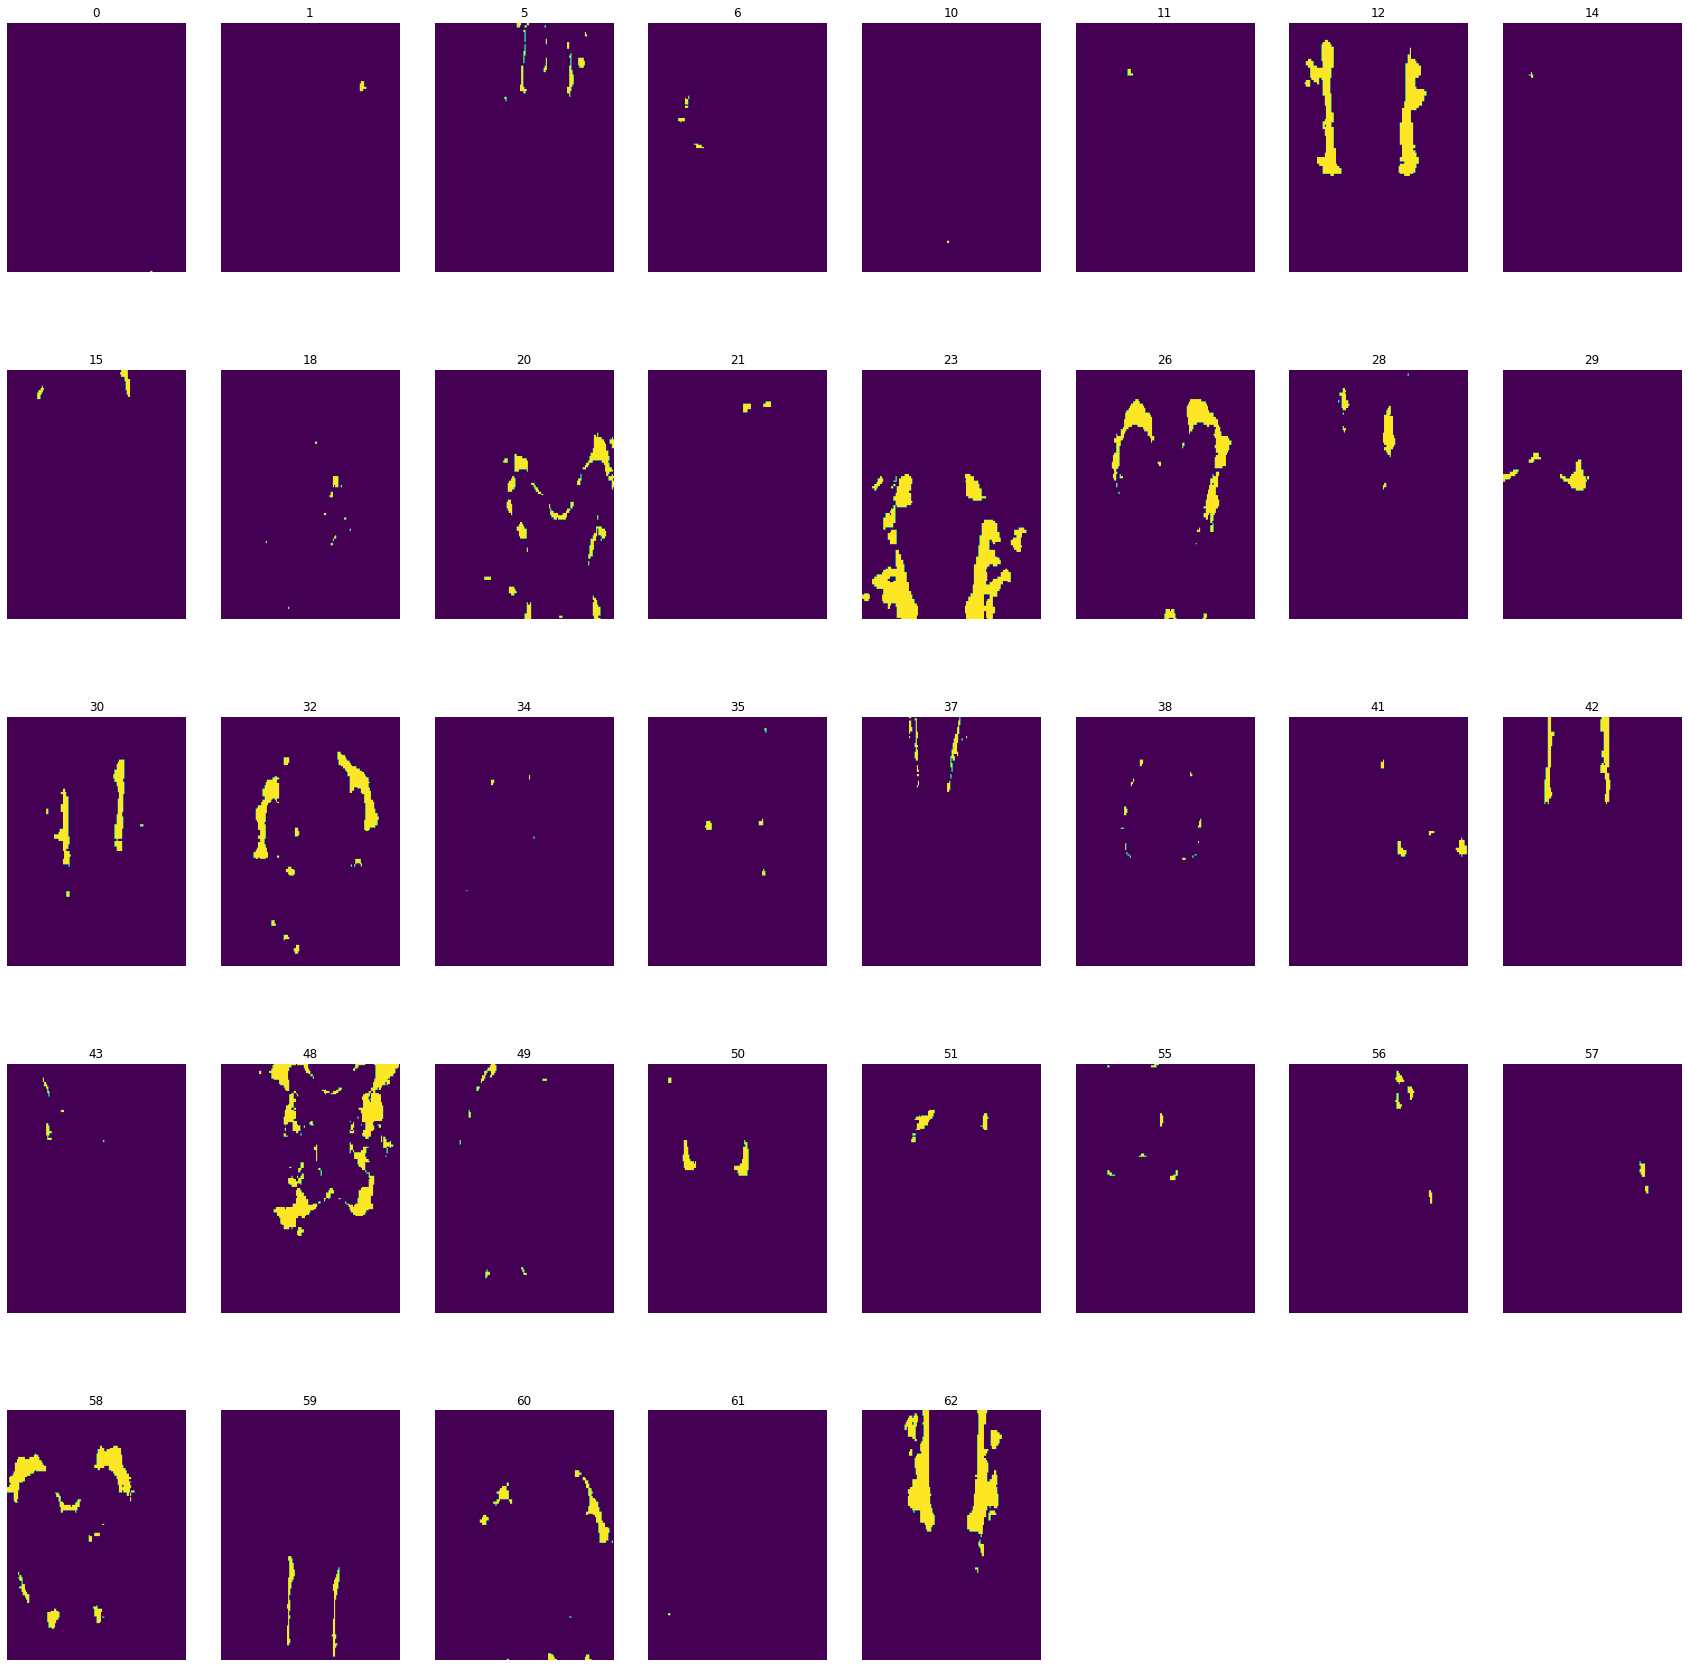

In [899]:
plt.figure(figsize=(30, 50))
count = 0
for i, img in enumerate(y):
    if torch.sum(img) > 0:
        plt.subplot(8, 8, count+1)
        plt.imshow(img); plt.axis('off');
        plt.title(i);
        count += 1
    

### look at calibrating the probability that a voxel is of class 1

In [900]:
from tqdm import tqdm

In [901]:
results = []
targets = []
ent_maps = []
dl = val_dataloader
with torch.no_grad():
    for x, y in tqdm(dl, total=len(dl), ncols=150, position=0, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        results.append(samples)
        targets.append(y)
        ent_maps.append(entropy_map_from_samples(samples))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.06it/s]


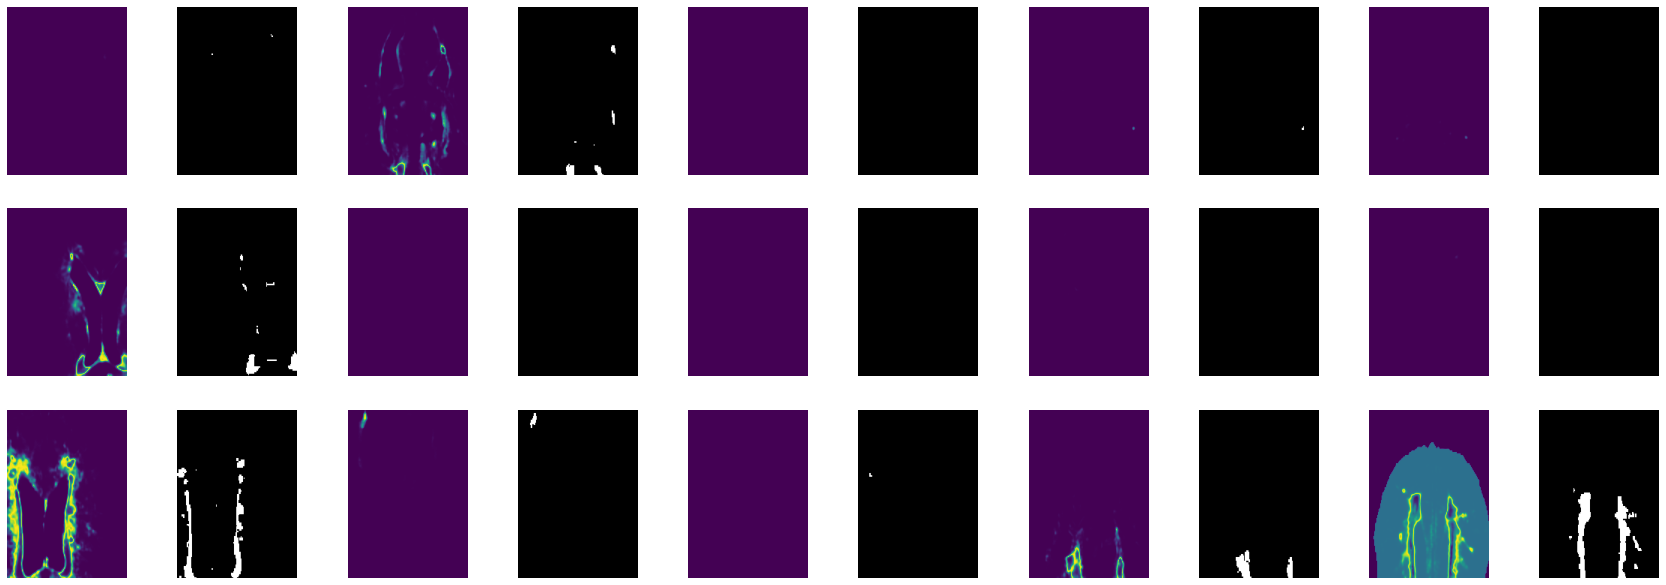

In [902]:
rand_inds_a = torch.randint(0, len(targets), (15,))
rand_inds_b = torch.randint(0, targets[0].shape[0], (15,))
plt.figure(figsize=(30, 10.5))
i = 0
for (ind_a, ind_b) in (zip(rand_inds_a, rand_inds_b)):
    plt.subplot(3, 10, i+1)
    batch = ent_maps[ind_a.item()]
    ind_b = ind_b.item()
    if batch.shape[0] <= ind_b:
        ind_b = batch.shape[0] - 1
    plt.imshow(batch[ind_b], cmap='viridis', vmin=0, vmax=0.7)
    plt.axis('off')
    
    plt.subplot(3, 10, i+2)
    plt.imshow(targets[ind_a][ind_b], cmap='gray')
    plt.axis('off')
    i += 2

In [903]:
rand_inds_a[6], rand_inds_b[6]

(tensor(26), tensor(0))

In [904]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [905]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [906]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.30s/it]


In [907]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [908]:
bin_accuracies

[0.0008255813154391944,
 0.09801679849624634,
 0.16801215708255768,
 0.2256283015012741,
 0.2795344591140747,
 0.3344956040382385,
 0.39252662658691406,
 0.45989739894866943,
 0.5457019209861755,
 0.6795651912689209,
 0.7185302376747131]

In [909]:
bin_confidences

[0.0003492761170491576,
 0.08931870758533478,
 0.19547560811042786,
 0.2973833680152893,
 0.3985329866409302,
 0.4992910325527191,
 0.5999894738197327,
 0.7009454369544983,
 0.8024765849113464,
 0.9071475863456726,
 0.9869731664657593]

In [910]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

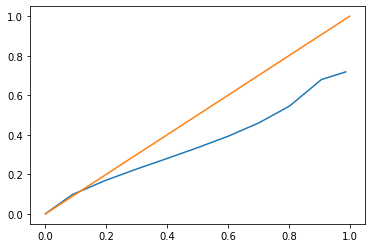

In [911]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);

In [912]:
exd = batch_t.expand(p1s.shape)

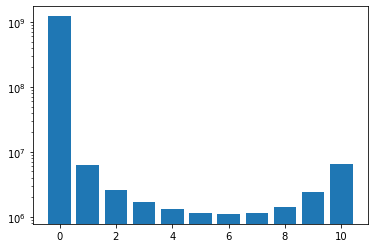

In [913]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

In [914]:
# now assess true calibration
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # split into bins
    bin_ids = place_in_bin(confidences)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        
        # number of predictions = to class 1
        c1_acc = (batch_t.expand(pred_classes.shape)[is_in_bin] == pred_classes[is_in_bin]).sum() / num_elem
        
        # average confidence of values in that bin
        c1_conf = confidences[is_in_bin].mean()
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)
    # 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:42<00:00, 10.06s/it]


In [915]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

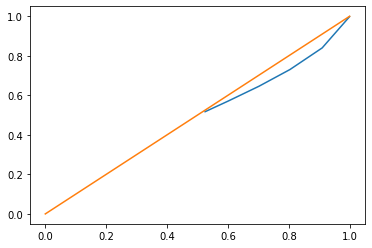

In [916]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1])

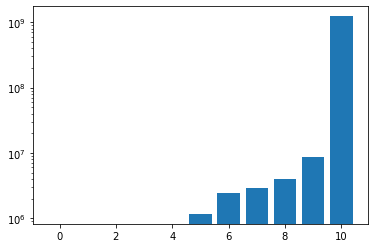

In [917]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [918]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    ent = ent_maps[batch_idx]
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [05:37<00:00,  8.45s/it]


In [919]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [920]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

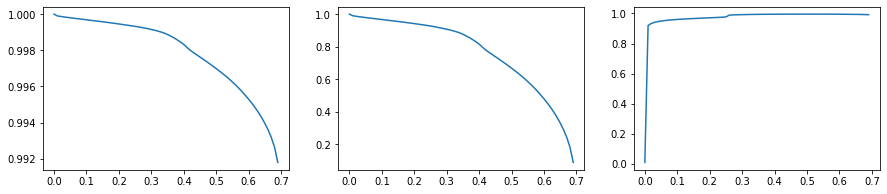

In [921]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs)
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus)
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu)